In [1]:
# Append the parent directory to the path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

# Import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from tqdm import tqdm

# Make the graphs pretty
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

In [ ]:
# Import custom classes and functions
from environments.base import BaseEnvironment, SimpleBilateralEnvironment
from environments.contextual import ContextualEnvironment, OrderBookEnvironment 
from learners.bandits import ConquerAndDivide

In [60]:
d = 8
T = 1000000

X = np.random.rand(T, d)
A = (np.random.rand(d, 2) - 0.5) * 2
L = np.max(np.sum(np.abs(A), axis=0))

Y = X@A
min_Y = np.min(Y)
max_Y = np.max(Y)
Y = (Y-min_Y)/(max_Y-min_Y)
L = L/(max_Y-min_Y)
print(L)
print(Y.shape)

mask = Y[:, 0] > Y[:, 1]
Y[mask] = Y[mask][:, ::-1]

0.7885561335865162
(1000000, 2)


In [65]:
def algo_run(d, T, L):
    order_book, valuation_sequence = X[:T, :d], Y[:T]
    env = OrderBookEnvironment(T, order_book, valuation_sequence)
    algo = ConquerAndDivide(T, d, L, env)
    algo.run()
    regret = env.get_policy_gft_having_adhoc_valuations() - algo.get_final_gft()
    return regret

In [66]:
combos = {}
for d in [2, 4, 8]:
    for T in [10**5 + i*10**4 for i in range(11)]:
        regrets = Parallel(n_jobs=-1)(
            delayed(algo_run)(d, T, L) for _ in range(100)
        )
        combos[(d, T)] = np.array(regrets)

100%|██████████| 200000/200000 [00:08<00:00, 24359.45it/s]


In [67]:
with open('../data/combos1.pkl', 'wb') as f:
    pickle.dump(combos, f)

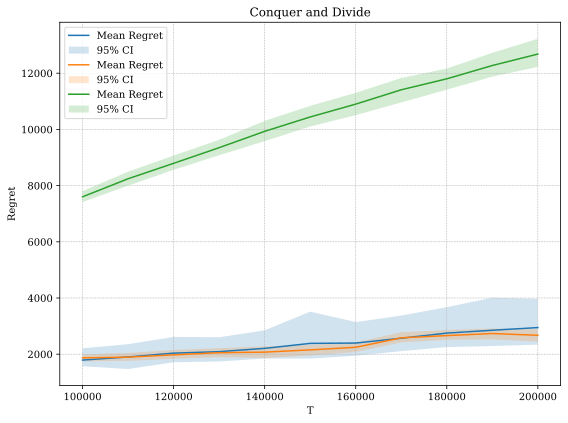

In [74]:
plt.figure(figsize=(8, 6))

for d in [2, 4, 8]:
    Ts = [10**5 + i*10**4 for i in range(11)]
    regrets_matrix = np.array([combos[(d, T)] for T in Ts])
    
    mean_regret = regrets_matrix.mean(axis=1)
    percentile_2_5 = np.percentile(regrets_matrix, 2.5, axis=1)
    percentile_97_5 = np.percentile(regrets_matrix, 97.5, axis=1)
    
    plt.plot(Ts, mean_regret, label='Mean Regret')
    plt.fill_between(Ts, percentile_2_5, percentile_97_5, alpha=0.2, label='95% CI')
    
    
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("Conquer and Divide")
plt.legend()
plt.tight_layout()
plt.show()